# 1. MRI - CT DataLoad & Preprocessing

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# pip install torchmetrics torch-fidelity

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import transforms, models
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.nn.functional import mse_loss

# # FOR COLAB
# # Load the .npy files
# train_input = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/train_input.npy').astype(np.float32)  # Convert to float32
# train_output = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/train_output.npy').astype(np.float32)  # Convert to float32
# val_input = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/val_input.npy').astype(np.float32)
# val_output = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/val_output.npy').astype(np.float32)
# test_input = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/Test_Patients_InputData/1BA058_input.npy').astype(np.float32)
# test_output = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/Test_Patients_OutputData/1BA058_output.npy').astype(np.float32)

# FOR PC
# Load the .npy files
train_input = np.load('./data(brain-new-10)/train_input.npy').astype(np.float32)  # Convert to float32
train_output = np.load('./data(brain-new-10)/train_output.npy').astype(np.float32)  # Convert to float32
val_input = np.load('./data(brain-new-10)/val_input.npy').astype(np.float32)
val_output = np.load('./data(brain-new-10)/val_output.npy').astype(np.float32)
test_input = np.load('./data(brain-new-10)/Test_Patients_InputData/1BA058_input.npy').astype(np.float32)
test_output = np.load('./data(brain-new-10)/Test_Patients_OutputData/1BA058_output.npy').astype(np.float32)

# Custom transformation function (no pairing needed for CycleGAN)
class SingleTransform:
    def __init__(self):
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(degrees=10),  # Random rotation within ±10 degrees
            T.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization
        ])

    def __call__(self, image):
        image = self.transforms(image)
        return image

# Custom Dataset Class for Single Domain (MRI or CT)
class SingleImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx][np.newaxis, :, :], dtype=torch.float32)  # [1, H, W]
        if self.transform:
            image = self.transform(image)
        return image

# Initialize transformations
transform = SingleTransform()

# Create Separate Datasets for MRI and CT
train_dataset_MRI = SingleImageDataset(train_input, transform=transform)
train_dataset_CT = SingleImageDataset(train_output, transform=transform)
val_dataset_MRI = SingleImageDataset(val_input, transform=transform)
val_dataset_CT = SingleImageDataset(val_output, transform=transform)
test_dataset_MRI = SingleImageDataset(test_input, transform=transform)
test_dataset_CT = SingleImageDataset(test_output, transform=transform)

# Create Separate DataLoaders
batch_size=20
train_loader_MRI = DataLoader(train_dataset_MRI, batch_size=batch_size, shuffle=True)
train_loader_CT = DataLoader(train_dataset_CT, batch_size=batch_size, shuffle=True)
val_loader_MRI = DataLoader(val_dataset_MRI, batch_size=batch_size, shuffle=False)
val_loader_CT = DataLoader(val_dataset_CT, batch_size=batch_size, shuffle=False)
test_loader_MRI = DataLoader(test_dataset_MRI, batch_size=batch_size, shuffle=False)
test_loader_CT = DataLoader(test_dataset_CT, batch_size=batch_size, shuffle=False)

# 2. Dataset Explanation and metadata Visualization

Training MRI set: 1610 images, Size: (1610, 256, 256)
Training CT set: 1610 images, Size: (1610, 256, 256)
Validation MRI set: 179 images, Size: (179, 256, 256)
Validation CT set: 179 images, Size: (179, 256, 256)
Testing MRI set: 197 images, Size: (197, 256, 256)
Testing CT set: 197 images, Size: (197, 256, 256)

Total MRI slices: 1986
Total CT slices: 1986
Total slices (MRI + CT): 3972


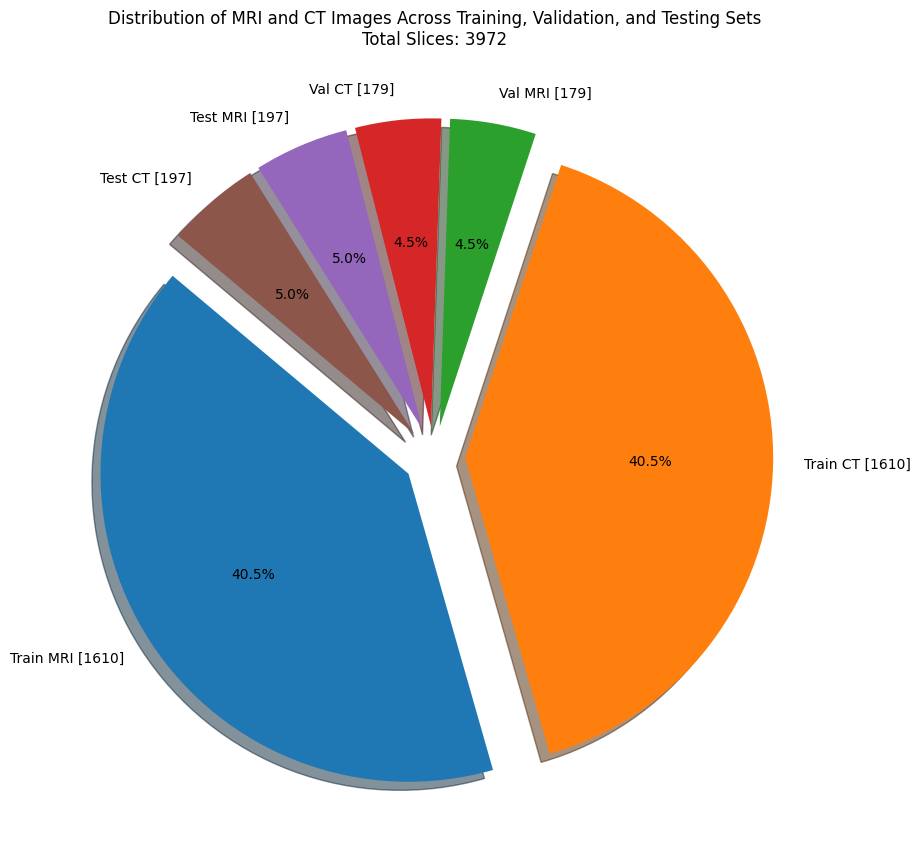

Training MRI set:
 - Number of images: 1610
 - First image size: (256, 256)
 - All images same size: True

Training CT set:
 - Number of images: 1610
 - First image size: (256, 256)
 - All images same size: True

Validation MRI set:
 - Number of images: 179
 - First image size: (256, 256)
 - All images same size: True

Validation CT set:
 - Number of images: 179
 - First image size: (256, 256)
 - All images same size: True

Testing MRI set:
 - Number of images: 197
 - First image size: (256, 256)
 - All images same size: True

Testing CT set:
 - Number of images: 197
 - First image size: (256, 256)
 - All images same size: True

MRI batch shape: torch.Size([20, 1, 256, 256])
CT batch shape: torch.Size([20, 1, 256, 256])
Using device: cuda


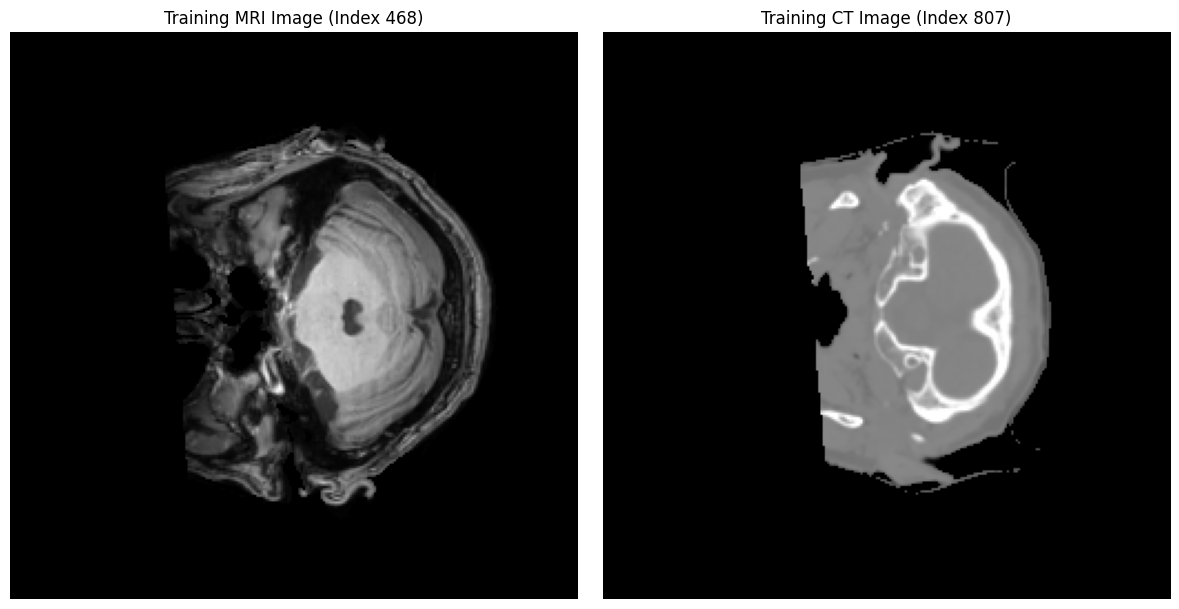

In [3]:
# # Print dataset information (updated for separate MRI and CT)
# print(f'Training MRI set: {len(train_dataset_MRI)} images, Size: {train_input.shape}')
# print(f'Training CT set: {len(train_dataset_CT)} images, Size: {train_output.shape}')
# print(f'Validation MRI set: {len(val_dataset_MRI)} images, Size: {val_input.shape}')
# print(f'Validation CT set: {len(val_dataset_CT)} images, Size: {val_output.shape}')
# print(f'Testing MRI set: {len(test_dataset_MRI)} images, Size: {test_input.shape}')
# print(f'Testing CT set: {len(test_dataset_CT)} images, Size: {test_output.shape}')

# # Create pie chart showing dataset sizes (split by domain)
# labels = ['Train MRI', 'Train CT', 'Val MRI', 'Val CT', 'Test MRI', 'Test CT']
# sizes = [
#     len(train_dataset_MRI), len(train_dataset_CT),
#     len(val_dataset_MRI), len(val_dataset_CT),
#     len(test_dataset_MRI), len(test_dataset_CT)
# ]
# explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # Explode all slices

# plt.figure(figsize=(10, 10))
# plt.pie(sizes, explode=explode, labels=[f"{label} [{size}]" for label, size in zip(labels, sizes)],
#         autopct='%1.1f%%', shadow=True, startangle=140)
# plt.title("Distribution of MRI and CT Images Across Training, Validation, and Testing Sets")
# plt.show()

# # Check sizes and uniformity (updated for single-domain datasets)
# def check_image_sizes(dataset, name):
#     first_size = dataset.data[0].shape
#     all_same_size = all(img.shape == first_size for img in dataset.data)
#     print(f"{name} set:")
#     print(f" - First image size: {first_size}")
#     print(f" - All images same size: {all_same_size}\n")

# check_image_sizes(train_dataset_MRI, "Training MRI")
# check_image_sizes(train_dataset_CT, "Training CT")
# check_image_sizes(val_dataset_MRI, "Validation MRI")
# check_image_sizes(val_dataset_CT, "Validation CT")
# check_image_sizes(test_dataset_MRI, "Testing MRI")
# check_image_sizes(test_dataset_CT, "Testing CT")

# # Verify loader outputs (no pairing, just single batches)
# for mri_batch in train_loader_MRI:
#     print(f"MRI batch shape: {mri_batch.shape}")
#     break
# for ct_batch in train_loader_CT:
#     print(f"CT batch shape: {ct_batch.shape}")
#     break

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# # Display a random MRI and CT image (not paired, just examples from each domain)
# random_idx_mri = random.randint(0, len(train_dataset_MRI) - 1)
# random_idx_ct = random.randint(0, len(train_dataset_CT) - 1)
# mri_image = train_dataset_MRI.data[random_idx_mri]  # Raw MRI image
# ct_image = train_dataset_CT.data[random_idx_ct]    # Raw CT image

# # Plot the examples
# plt.figure(figsize=(12, 6))

# # MRI image
# plt.subplot(1, 2, 1)
# plt.imshow(mri_image.squeeze(), cmap='gray')
# plt.title(f'Training MRI Image (Index {random_idx_mri})')
# plt.axis('off')

# # CT image
# plt.subplot(1, 2, 2)
# plt.imshow(ct_image.squeeze(), cmap='gray')
# plt.title(f'Training CT Image (Index {random_idx_ct})')
# plt.axis('off')

# plt.tight_layout()
# plt.show()
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Print dataset information (updated to include total slices)
print(f'Training MRI set: {len(train_dataset_MRI)} images, Size: {train_input.shape}')
print(f'Training CT set: {len(train_dataset_CT)} images, Size: {train_output.shape}')
print(f'Validation MRI set: {len(val_dataset_MRI)} images, Size: {val_input.shape}')
print(f'Validation CT set: {len(val_dataset_CT)} images, Size: {val_output.shape}')
print(f'Testing MRI set: {len(test_dataset_MRI)} images, Size: {test_input.shape}')
print(f'Testing CT set: {len(test_dataset_CT)} images, Size: {test_output.shape}')

# Calculate and display total number of slices
total_slices_mri = len(train_dataset_MRI) + len(val_dataset_MRI) + len(test_dataset_MRI)
total_slices_ct = len(train_dataset_CT) + len(val_dataset_CT) + len(test_dataset_CT)
total_slices = total_slices_mri + total_slices_ct  # Total across both domains
print(f"\nTotal MRI slices: {total_slices_mri}")
print(f"Total CT slices: {total_slices_ct}")
print(f"Total slices (MRI + CT): {total_slices}")

# Create pie chart showing dataset sizes (split by domain) with total slices in title
labels = ['Train MRI', 'Train CT', 'Val MRI', 'Val CT', 'Test MRI', 'Test CT']
sizes = [
    len(train_dataset_MRI), len(train_dataset_CT),
    len(val_dataset_MRI), len(val_dataset_CT),
    len(test_dataset_MRI), len(test_dataset_CT)
]
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # Explode all slices

plt.figure(figsize=(10, 10))
plt.pie(sizes, explode=explode, labels=[f"{label} [{size}]" for label, size in zip(labels, sizes)],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title(f"Distribution of MRI and CT Images Across Training, Validation, and Testing Sets\nTotal Slices: {total_slices}", pad=20)
plt.show()

# Check sizes and uniformity (updated for single-domain datasets)
def check_image_sizes(dataset, name):
    first_size = dataset.data[0].shape
    all_same_size = all(img.shape == first_size for img in dataset.data)
    num_images = len(dataset)
    print(f"{name} set:")
    print(f" - Number of images: {num_images}")
    print(f" - First image size: {first_size}")
    print(f" - All images same size: {all_same_size}\n")

check_image_sizes(train_dataset_MRI, "Training MRI")
check_image_sizes(train_dataset_CT, "Training CT")
check_image_sizes(val_dataset_MRI, "Validation MRI")
check_image_sizes(val_dataset_CT, "Validation CT")
check_image_sizes(test_dataset_MRI, "Testing MRI")
check_image_sizes(test_dataset_CT, "Testing CT")

# Verify loader outputs (no pairing, just single batches)
for mri_batch in train_loader_MRI:
    print(f"MRI batch shape: {mri_batch.shape}")
    break
for ct_batch in train_loader_CT:
    print(f"CT batch shape: {ct_batch.shape}")
    break

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Display a random MRI and CT image (not paired, just examples from each domain)
random_idx_mri = random.randint(0, len(train_dataset_MRI) - 1)
random_idx_ct = random.randint(0, len(train_dataset_CT) - 1)
mri_image = train_dataset_MRI.data[random_idx_mri]  # Raw MRI image
ct_image = train_dataset_CT.data[random_idx_ct]    # Raw CT image

# Plot the examples
plt.figure(figsize=(12, 6))

# MRI image
plt.subplot(1, 2, 1)
plt.imshow(mri_image.squeeze(), cmap='gray')
plt.title(f'Training MRI Image (Index {random_idx_mri})')
plt.axis('off')

# CT image
plt.subplot(1, 2, 2)
plt.imshow(ct_image.squeeze(), cmap='gray')
plt.title(f'Training CT Image (Index {random_idx_ct})')
plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Training and Validation Result Visualization

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Initialize dictionaries to store metrics for plotting
training_metrics = {
    "epoch": [],
    "D_MRI Loss": [],
    "D_CT Loss": [],
    "G Loss": [],
    "GAN MRI2CT Loss": [],
    "GAN CT2MRI Loss": [],
    "Cycle MRI Loss": [],
    "Cycle CT Loss": [],
    "Perceptual Loss": [],
    "D_MRI Real Acc": [],
    "D_MRI Fake Acc": [],
    "D_CT Real Acc": [],
    "D_CT Fake Acc": []
}

validation_metrics = {
    "epoch": [],
    "MRI MSE": [],
    "MRI SSIM": [],
    "MRI FID": [],
    "MRI VGG Loss": [],
    "CT MSE": [],
    "CT SSIM": [],
    "CT FID": [],
    "CT VGG Loss": [],
    "Cycle MRI MSE": [],
    "Cycle MRI SSIM": [],
    "Cycle MRI FID": [],
    "Cycle CT MSE": [],
    "Cycle CT SSIM": [],
    "Cycle CT FID": []
}

def log_training_metrics(epoch, d_loss_mri, d_loss_ct, g_loss, gan_loss_mri2ct, gan_loss_ct2mri, cycle_loss_mri, cycle_loss_ct, perceptual_loss, d_mri_real_acc, d_mri_fake_acc, d_ct_real_acc, d_ct_fake_acc):
    """Log training metrics after every batch."""
    training_metrics["epoch"].append(epoch)
    training_metrics["D_MRI Loss"].append(d_loss_mri)
    training_metrics["D_CT Loss"].append(d_loss_ct)
    training_metrics["G Loss"].append(g_loss)
    training_metrics["GAN MRI2CT Loss"].append(gan_loss_mri2ct)
    training_metrics["GAN CT2MRI Loss"].append(gan_loss_ct2mri)
    training_metrics["Cycle MRI Loss"].append(cycle_loss_mri)
    training_metrics["Cycle CT Loss"].append(cycle_loss_ct)
    training_metrics["Perceptual Loss"].append(perceptual_loss)
    training_metrics["D_MRI Real Acc"].append(d_mri_real_acc)
    training_metrics["D_MRI Fake Acc"].append(d_mri_fake_acc)
    training_metrics["D_CT Real Acc"].append(d_ct_real_acc)
    training_metrics["D_CT Fake Acc"].append(d_ct_fake_acc)

def log_validation_metrics(epoch, mse_ct, ssim_ct, fid_ct, vgg_ct, mse_mri, ssim_mri, fid_mri, vgg_mri, cycle_metrics):
    """Log validation metrics after each epoch."""
    validation_metrics["epoch"].append(epoch)
    validation_metrics["MRI MSE"].append(mse_mri)
    validation_metrics["MRI SSIM"].append(ssim_mri)
    validation_metrics["MRI FID"].append(fid_mri)
    validation_metrics["MRI VGG Loss"].append(vgg_mri)
    validation_metrics["CT MSE"].append(mse_ct)
    validation_metrics["CT SSIM"].append(ssim_ct)
    validation_metrics["CT FID"].append(fid_ct)
    validation_metrics["CT VGG Loss"].append(vgg_ct)
    validation_metrics["Cycle MRI MSE"].append(cycle_metrics['cycle_mse_MRI'])
    validation_metrics["Cycle MRI SSIM"].append(cycle_metrics['cycle_ssim_MRI'])
    validation_metrics["Cycle MRI FID"].append(cycle_metrics['cycle_fid_MRI'])
    validation_metrics["Cycle CT MSE"].append(cycle_metrics['cycle_mse_CT'])
    validation_metrics["Cycle CT SSIM"].append(cycle_metrics['cycle_ssim_CT'])
    validation_metrics["Cycle CT FID"].append(cycle_metrics['cycle_fid_CT'])

def plot_training_metrics(training_metrics):
    """Plot training metrics in a 4x1 layout."""
    fig, axes = plt.subplots(4, 1, figsize=(12, 24))

    # Helper function to check for empty data
    def safe_max(data, default=1):
        return max(data) if data else default

    # 1: D Losses
    if training_metrics["D_MRI Loss"] and training_metrics["D_CT Loss"]:
        axes[0].plot(training_metrics["epoch"], training_metrics["D_MRI Loss"], label="D_MRI Loss")
        axes[0].plot(training_metrics["epoch"], training_metrics["D_CT Loss"], label="D_CT Loss")
        axes[0].set_ylim(0, safe_max(training_metrics["D_MRI Loss"] + training_metrics["D_CT Loss"]) * 1.2)
        axes[0].set_title("Discriminator Losses")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()
        axes[0].grid()
    else:
        axes[0].text(0.5, 0.5, "No data for Discriminator Losses", ha='center', va='center')

    # 2: G Loss, GAN Losses
    if training_metrics["G Loss"] and training_metrics["GAN MRI2CT Loss"] and training_metrics["GAN CT2MRI Loss"]:
        axes[1].plot(training_metrics["epoch"], training_metrics["G Loss"], label="G Loss")
        axes[1].plot(training_metrics["epoch"], training_metrics["GAN MRI2CT Loss"], label="GAN MRI2CT Loss")
        axes[1].plot(training_metrics["epoch"], training_metrics["GAN CT2MRI Loss"], label="GAN CT2MRI Loss")
        axes[1].set_ylim(0, safe_max(training_metrics["G Loss"] + training_metrics["GAN MRI2CT Loss"] + training_metrics["GAN CT2MRI Loss"]) * 1.2)
        axes[1].set_title("Generator and GAN Losses")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid()
    else:
        axes[1].text(0.5, 0.5, "No data for Generator or GAN Losses", ha='center', va='center')

    # 3: Cycle and Perceptual Losses
    if training_metrics["Cycle MRI Loss"] and training_metrics["Cycle CT Loss"] and training_metrics["Perceptual Loss"]:
        axes[2].plot(training_metrics["epoch"], training_metrics["Cycle MRI Loss"], label="Cycle MRI Loss")
        axes[2].plot(training_metrics["epoch"], training_metrics["Cycle CT Loss"], label="Cycle CT Loss")
        axes[2].plot(training_metrics["epoch"], training_metrics["Perceptual Loss"], label="Perceptual Loss")
        axes[2].set_ylim(0, safe_max(training_metrics["Cycle MRI Loss"] + training_metrics["Cycle CT Loss"] + training_metrics["Perceptual Loss"]) * 1.2)
        axes[2].set_title("Cycle and Perceptual Losses")
        axes[2].set_xlabel("Epoch")
        axes[2].set_ylabel("Loss")
        axes[2].legend()
        axes[2].grid()
    else:
        axes[2].text(0.5, 0.5, "No data for Cycle or Perceptual Losses", ha='center', va='center')

    # 4: Discriminator Accuracies
    if training_metrics["D_MRI Real Acc"] and training_metrics["D_MRI Fake Acc"] and training_metrics["D_CT Real Acc"] and training_metrics["D_CT Fake Acc"]:
        axes[3].plot(training_metrics["epoch"], training_metrics["D_MRI Real Acc"], label="D_MRI Real Acc")
        axes[3].plot(training_metrics["epoch"], training_metrics["D_MRI Fake Acc"], label="D_MRI Fake Acc")
        axes[3].plot(training_metrics["epoch"], training_metrics["D_CT Real Acc"], label="D_CT Real Acc")
        axes[3].plot(training_metrics["epoch"], training_metrics["D_CT Fake Acc"], label="D_CT Fake Acc")
        axes[3].set_ylim(0, 1)
        axes[3].set_title("Discriminator Accuracies")
        axes[3].set_xlabel("Epoch")
        axes[3].set_ylabel("Accuracy")
        axes[3].legend()
        axes[3].grid()
    else:
        axes[3].text(0.5, 0.5, "No data for Discriminator Accuracies", ha='center', va='center')

    plt.tight_layout()
    plt.show()

def plot_validation_metrics(validation_metrics):
    """Plot validation metrics in a 6x1 layout for MRI, CT, and Cycle metrics."""
    fig, axes = plt.subplots(6, 1, figsize=(12, 36))

    # Convert tensors to NumPy if needed
    def to_numpy(data):
        return [d.cpu().numpy() if torch.is_tensor(d) else d for d in data]

    epoch = validation_metrics["epoch"]
    mri_mse, mri_ssim, mri_fid, mri_vgg = map(to_numpy, [validation_metrics["MRI MSE"], validation_metrics["MRI SSIM"], validation_metrics["MRI FID"], validation_metrics["MRI VGG Loss"]])
    ct_mse, ct_ssim, ct_fid, ct_vgg = map(to_numpy, [validation_metrics["CT MSE"], validation_metrics["CT SSIM"], validation_metrics["CT FID"], validation_metrics["CT VGG Loss"]])
    cycle_mri_mse, cycle_mri_ssim, cycle_mri_fid = map(to_numpy, [validation_metrics["Cycle MRI MSE"], validation_metrics["Cycle MRI SSIM"], validation_metrics["Cycle MRI FID"]])
    cycle_ct_mse, cycle_ct_ssim, cycle_ct_fid = map(to_numpy, [validation_metrics["Cycle CT MSE"], validation_metrics["Cycle CT SSIM"], validation_metrics["Cycle CT FID"]])

    # 1: MRI Validation Metrics
    axes[0].plot(epoch, mri_fid, label="MRI FID", color='blue')
    axes[0].plot(epoch, mri_mse, label="MRI MSE", color='green')
    axes[0].plot(epoch, mri_ssim, label="MRI SSIM", color='red')
    axes[0].plot(epoch, mri_vgg, label="MRI VGG Loss", color='purple')
    axes[0].set_title("MRI Validation Metrics")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Value")
    axes[0].legend()
    axes[0].grid()

    # 2: CT Validation Metrics
    axes[1].plot(epoch, ct_fid, label="CT FID", color='blue')
    axes[1].plot(epoch, ct_mse, label="CT MSE", color='green')
    axes[1].plot(epoch, ct_ssim, label="CT SSIM", color='red')
    axes[1].plot(epoch, ct_vgg, label="CT VGG Loss", color='purple')
    axes[1].set_title("CT Validation Metrics")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Value")
    axes[1].legend()
    axes[1].grid()

    # 3: Cycle MRI MSE
    axes[2].plot(epoch, cycle_mri_mse, label="Cycle MRI MSE", color='green')
    axes[2].set_title("Cycle MRI MSE Over Epochs")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("MSE")
    axes[2].legend()
    axes[2].grid()

    # 4: Cycle MRI SSIM
    axes[3].plot(epoch, cycle_mri_ssim, label="Cycle MRI SSIM", color='red')
    axes[3].set_title("Cycle MRI SSIM Over Epochs")
    axes[3].set_xlabel("Epoch")
    axes[3].set_ylabel("SSIM (-1 to 1)")
    axes[3].legend()
    axes[3].grid()

    # 5: Cycle CT MSE
    axes[4].plot(epoch, cycle_ct_mse, label="Cycle CT MSE", color='green')
    axes[4].set_title("Cycle CT MSE Over Epochs")
    axes[4].set_xlabel("Epoch")
    axes[4].set_ylabel("MSE")
    axes[4].legend()
    axes[4].grid()

    # 6: Cycle CT SSIM
    axes[5].plot(epoch, cycle_ct_ssim, label="Cycle CT SSIM", color='red')
    axes[5].set_title("Cycle CT SSIM Over Epochs")
    axes[5].set_xlabel("Epoch")
    axes[5].set_ylabel("SSIM (-1 to 1)")
    axes[5].legend()
    axes[5].grid()

    plt.tight_layout()
    plt.show()

# Example usage in training loop (update the training function call accordingly):
# In train_cyclegan, replace the log_training_metrics call with:
# log_training_metrics(
#     (epoch + ((i+1)/len(train_loader_MRI))), d_loss_MRI.item(), d_loss_CT.item(), loss_G.item(),
#     loss_GAN_MRI2CT.item(), loss_GAN_CT2MRI.item(), loss_cycle_MRI.item(), loss_cycle_CT.item(),
#     (loss_perceptual_MRI2CT.item() + loss_perceptual_CT2MRI.item()) / 2,
#     D_MRI_real_acc, D_MRI_fake_acc, D_CT_real_acc, D_CT_fake_acc
# )

# In train_cyclegan, replace the log_validation_metrics call with:
# log_validation_metrics(
#     epoch + 1, val_mse_CT, val_ssim_CT, val_fid_CT, val_vgg_CT,
#     val_mse_MRI, val_ssim_MRI, val_fid_MRI, val_vgg_MRI, cycle_metrics
# )

# After training, call:
# plot_training_metrics(training_metrics)
# plot_validation_metrics(validation_metrics)

# 4. Special Training/Calculation Functions :-
## perceptual_loss || compute_gradient_penalty || Validation

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19, vgg16
from torchvision.transforms import Resize
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image import FrechetInceptionDistance

# Ensure device is set (assuming it’s defined globally in the original code)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom perceptual loss function (updated to match CycleGAN setup)
def perceptual_loss(y_true, y_pred):
    # Convert grayscale to RGB by replicating the single channel to 3 channels
    y_true_rgb = y_true.repeat(1, 3, 1, 1)  # [batch_size, 1, H, W] -> [batch_size, 3, H, W]
    y_pred_rgb = y_pred.repeat(1, 3, 1, 1)

    # Use the globally defined vgg instance from the original code
    global vgg
    y_true_features = vgg(y_true_rgb)
    y_pred_features = vgg(y_pred_rgb)

    return F.mse_loss(y_pred_features, y_true_features.detach())

# Function to compute gradient penalty (aligned with original CycleGAN implementation)
def compute_gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    # Generate random weight for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    # Interpolate between real and fake images
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)

    # Get discriminator output for interpolated images
    d_interpolates = discriminator(interpolates)

    # Compute gradients of the output with respect to the interpolated images
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute the L2 norm of the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Perceptual Loss helper class using VGG16 (updated to match original VGG19 usage)
class VGGPerceptualLoss(nn.Module):
    def __init__(self, device):
        super(VGGPerceptualLoss, self).__init__()
        # Use VGG19 to match the original CycleGAN code
        vgg = vgg19(weights='DEFAULT').features.eval()  # Use full VGG19 features as in original
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)
        self.resize = Resize((224, 224))

    def forward(self, fake, real):
        # Convert grayscale to RGB
        fake_3ch = fake.repeat(1, 3, 1, 1)
        real_3ch = real.repeat(1, 3, 1, 1)
        fake_resized = self.resize(fake_3ch)
        real_resized = self.resize(real_3ch)
        fake_features = self.vgg(fake_resized)
        real_features = self.vgg(real_resized)
        return F.mse_loss(fake_features, real_features.detach())

# Validation function for CycleGAN (updated for dual-domain evaluation)
def validate(G_MRI2CT, G_CT2MRI, val_loader_MRI, val_loader_CT):
    G_MRI2CT.eval()  # Set MRI -> CT generator to evaluation mode
    G_CT2MRI.eval()  # Set CT -> MRI generator to evaluation mode
    total_mse_mri, total_ssim_mri, total_fid_mri, total_vgg_mri = 0, 0, 0, 0
    total_mse_ct, total_ssim_ct, total_fid_ct, total_vgg_ct = 0, 0, 0, 0

    # Use globally defined fid_metric from original code
    global fid_metric
    fid_metric.reset()  # Reset FID metric
    perceptual_loss_fn = VGGPerceptualLoss(device)

    with torch.no_grad():
        # Validate MRI -> CT translation
        for mri_images in val_loader_MRI:
            mri_images = mri_images.to(device)
            fake_ct_images = G_MRI2CT(mri_images)

            # MSE Calculation (assuming val_loader_MRI provides ground truth CT)
            batch_mse_ct = F.mse_loss(fake_ct_images, mri_images).item()  # Adjust if paired data available
            total_mse_ct += batch_mse_ct

            # SSIM Calculation
            batch_ssim_ct = 0
            fake_ct_np = fake_ct_images.squeeze(1).cpu().numpy()
            mri_np = mri_images.squeeze(1).cpu().numpy()
            for i in range(fake_ct_np.shape[0]):
                batch_ssim_ct += ssim(fake_ct_np[i], mri_np[i], data_range=2.0)  # Assuming [-1, 1] range
            total_ssim_ct += batch_ssim_ct / fake_ct_np.shape[0]

            # FID Calculation
            fake_ct_3ch = fake_ct_images.repeat(1, 3, 1, 1)
            real_mri_3ch = mri_images.repeat(1, 3, 1, 1)
            fake_ct_3ch = ((fake_ct_3ch + 1) / 2 * 255).to(torch.uint8)
            real_mri_3ch = ((real_mri_3ch + 1) / 2 * 255).to(torch.uint8)
            fid_metric.update(real_mri_3ch, real=True)
            fid_metric.update(fake_ct_3ch, real=False)
            total_fid_ct += fid_metric.compute().item()
            fid_metric.reset()

            # Perceptual Loss Calculation
            batch_vgg_ct = perceptual_loss_fn(fake_ct_images, mri_images).item()
            total_vgg_ct += batch_vgg_ct

        # Validate CT -> MRI translation
        for ct_images in val_loader_CT:
            ct_images = ct_images.to(device)
            fake_mri_images = G_CT2MRI(ct_images)

            # MSE Calculation (assuming val_loader_CT provides ground truth MRI)
            batch_mse_mri = F.mse_loss(fake_mri_images, ct_images).item()  # Adjust if paired data available
            total_mse_mri += batch_mse_mri

            # SSIM Calculation
            batch_ssim_mri = 0
            fake_mri_np = fake_mri_images.squeeze(1).cpu().numpy()
            ct_np = ct_images.squeeze(1).cpu().numpy()
            for i in range(fake_mri_np.shape[0]):
                batch_ssim_mri += ssim(fake_mri_np[i], ct_np[i], data_range=2.0)  # Assuming [-1, 1] range
            total_ssim_mri += batch_ssim_mri / fake_mri_np.shape[0]

            # FID Calculation
            fake_mri_3ch = fake_mri_images.repeat(1, 3, 1, 1)
            real_ct_3ch = ct_images.repeat(1, 3, 1, 1)
            fake_mri_3ch = ((fake_mri_3ch + 1) / 2 * 255).to(torch.uint8)
            real_ct_3ch = ((real_ct_3ch + 1) / 2 * 255).to(torch.uint8)
            fid_metric.update(real_ct_3ch, real=True)
            fid_metric.update(fake_mri_3ch, real=False)
            total_fid_mri += fid_metric.compute().item()
            fid_metric.reset()

            # Perceptual Loss Calculation
            batch_vgg_mri = perceptual_loss_fn(fake_mri_images, ct_images).item()
            total_vgg_mri += batch_vgg_mri

    # Average the metrics over the validation sets
    avg_mse_mri = total_mse_mri / len(val_loader_CT)  # Note: Assuming unpaired data; adjust if paired
    avg_ssim_mri = total_ssim_mri / len(val_loader_CT)
    avg_fid_mri = total_fid_mri / len(val_loader_CT)
    avg_vgg_mri = total_vgg_mri / len(val_loader_CT)

    avg_mse_ct = total_mse_ct / len(val_loader_MRI)
    avg_ssim_ct = total_ssim_ct / len(val_loader_MRI)
    avg_fid_ct = total_fid_ct / len(val_loader_MRI)
    avg_vgg_ct = total_vgg_ct / len(val_loader_MRI)

    G_MRI2CT.train()  # Restore training mode
    G_CT2MRI.train()
    return (avg_mse_mri, avg_ssim_mri, avg_fid_mri, avg_vgg_mri), (avg_mse_ct, avg_ssim_ct, avg_fid_ct, avg_vgg_ct)

# Example integration with CycleGAN training loop (update train_cyclegan accordingly):
# """
# In the train_cyclegan function, replace the validation block with:
# val_metrics_mri, val_metrics_ct = validate(G_MRI2CT, G_CT2MRI, val_loader_MRI, val_loader_CT)
# val_mse_mri, val_ssim_mri, val_fid_mri, val_vgg_mri = val_metrics_mri
# val_mse_ct, val_ssim_ct, val_fid_ct, val_vgg_ct = val_metrics_ct
# cycle_metrics = calculate_cycle_metrics(
#     mri_images, fake_images_MRI2CT, cycled_mri, ct_images, fake_images_CT2MRI, cycled_ct
# )
# """

# 5. Trained Model Creation
## Using Generator & Discriminator Training and learning

In [6]:
# Define UNet Generator
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        # Encoder: Each encoder block downsamples the input by a factor of 2
        self.enc1 = self.encoder_block(1, 64)  # Input: 256x256x1 -> Output: 128x128x64
        self.enc2 = self.encoder_block(64, 128)  # Input: 128x128x64 -> Output: 64x64x128
        self.enc3 = self.encoder_block(128, 256)  # Input: 64x64x128 -> Output: 32x32x256
        self.enc4 = self.encoder_block(256, 512)  # Input: 32x32x256 -> Output: 16x16x512

        # Bottleneck: Further compresses spatial dimensions
        self.bottleneck = self.encoder_block(512, 1024)  # Input: 16x16x512 -> Output: 8x8x1024

        # Decoder: Each decoder block upsamples the input by a factor of 2
        self.dec4 = self.decoder_block(1024, 512)  # Input: 8x8x1024 -> Output: 16x16x512
        self.dec3 = self.decoder_block(512 + 512, 256)  # Input: 16x16x1024 -> Output: 32x32x256
        self.dec2 = self.decoder_block(256 + 256, 128)  # Input: 32x32x512 -> Output: 64x64x128
        self.dec1 = self.decoder_block(128 + 128, 64)  # Input: 64x64x256 -> Output: 128x128x64

        # Final upsampling layer to restore the original spatial size
        self.final_upsample = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)  # Output: 256x256x1

        # Activation function for final output
        self.tanh = nn.Tanh()

    def encoder_block(self, in_channels, out_channels):
        """Defines an encoder block with Conv2D, BatchNorm, LeakyReLU, and Dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),  # Downsampling
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.14),  # Slight negative slope for ReLU
            nn.Dropout(p=0.1)
        )

    def decoder_block(self, in_channels, out_channels):
        """Defines a decoder block with ConvTranspose2D, BatchNorm, LeakyReLU, and Dropout"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),  # Upsampling
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.14),
            nn.Dropout(p=0.1)
        )

    def forward(self, x):
        # --- Encoder ---
        enc1 = self.enc1(x)  # 256x256x1 -> 128x128x64
        enc2 = self.enc2(enc1)  # 128x128x64 -> 64x64x128
        enc3 = self.enc3(enc2)  # 64x64x128 -> 32x32x256
        enc4 = self.enc4(enc3)  # 32x32x256 -> 16x16x512

        # Bottleneck
        bottleneck = self.bottleneck(enc4)  # 16x16x512 -> 8x8x1024

        # --- Decoder ---
        # Upsample bottleneck and concatenate with corresponding encoder output
        dec4 = self.dec4(bottleneck)  # 8x8x1024 -> 16x16x512
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concat: 16x16x512 + 16x16x512 -> 16x16x1024

        dec3 = self.dec3(dec4)  # 16x16x1024 -> 32x32x256
        dec3 = torch.cat((dec3, enc3), dim=1)  # Concat: 32x32x256 + 32x32x256 -> 32x32x512

        dec2 = self.dec2(dec3)  # 32x32x512 -> 64x64x128
        dec2 = torch.cat((dec2, enc2), dim=1)  # Concat: 64x64x128 + 64x64x128 -> 64x64x256

        dec1 = self.dec1(dec2)  # 64x64x256 -> 128x128x64
        dec1 = torch.cat((dec1, enc1), dim=1)  # Concat: 128x128x64 + 128x128x64 -> 128x128x128

        # Final upsampling to restore original input size
        out = self.final_upsample(dec1)  # 128x128x128 -> 256x256x1

        # Apply activation function for output normalization
        return self.tanh(out)

# # Instantiate the U-Net model
# model = UNetGenerator()

# Define PatchGAN Discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=2):  # Input: Concatenated MRI and CT (2 channels)
        super(PatchGANDiscriminator, self).__init__()

        self.model = nn.Sequential(
            # Input block
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.32),

            # Downsampling blocks (reduced to 3 layers)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.32),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.32),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.32),

            # Final output layer: Patch-level predictions
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Adjusted output layer
        )
        self.sigmoid = nn.Sigmoid()  # Added as binary_cross_entropy expects values between 0 and 1

    def forward(self, x):
        out = self.model(x)  # Output shape: [batch_size, 1, H/8, W/8]
        return self.sigmoid(out)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import Resize
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image import FrechetInceptionDistance
import torch.nn.functional as F

# Assuming UNetGenerator and PatchGANDiscriminator are defined elsewhere

# Loss Functions
criterion_GAN = nn.BCELoss()  # Adversarial loss (GAN)
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss
criterion_pixelwise = nn.L1Loss()  # Pixel-wise L1 loss (reused from Pix2Pix)
vgg = models.vgg19(weights='DEFAULT').features.eval().to(device)  # Pre-trained VGG for perceptual loss
fid_metric = FrechetInceptionDistance().to(device)  # FID for validation

# Hyperparameters
lambda_cycle = 10.0  # Weight for cycle consistency (standard starting point)
lambda_identity = 5.0  # Weight for identity loss (can tune or set to 0)
lambda_perceptual = 0.7  # Your existing perceptual loss weight
lambda_gp = 12  # Gradient penalty weight from Pix2Pix

# Early Stopping Variables
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Models (Two Generators, Two Discriminators)
G_MRI2CT = UNetGenerator().to(device)  # MRI -> CT
G_CT2MRI = UNetGenerator().to(device)  # CT -> MRI
D_MRI = PatchGANDiscriminator(in_channels=1).to(device)  # MRI domain discriminator
D_CT = PatchGANDiscriminator(in_channels=1).to(device)  # CT domain discriminator

# Optimizers
optimizer_G = optim.Adam(
    list(G_MRI2CT.parameters()) + list(G_CT2MRI.parameters()),
    lr=0.00031, betas=(0.5, 0.999)
)
optimizer_D_MRI = optim.Adam(D_MRI.parameters(), lr=0.00006, betas=(0.5, 0.999))
optimizer_D_CT = optim.Adam(D_CT.parameters(), lr=0.00006, betas=(0.5, 0.999))

# Learning Rate Schedulers
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=4)
scheduler_D_MRI = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D_MRI, mode='min', factor=0.5, patience=4)
scheduler_D_CT = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D_CT, mode='min', factor=0.5, patience=4)

# Gradient Penalty
def compute_gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Custom Perceptual Loss Function
def perceptual_loss(y_true, y_pred):
    y_true_rgb = y_true.repeat(1, 3, 1, 1)  # Convert grayscale to RGB
    y_pred_rgb = y_pred.repeat(1, 3, 1, 1)
    y_true_features = vgg(y_true_rgb)
    y_pred_features = vgg(y_pred_rgb)
    return F.mse_loss(y_pred_features, y_true_features.detach())

# VGG Perceptual Loss Class
class VGGPerceptualLoss(nn.Module):
    def __init__(self, device):
        super(VGGPerceptualLoss, self).__init__()
        self.vgg = vgg
        self.resize = Resize((224, 224))

    def forward(self, fake, real):
        fake_3ch = fake.repeat(1, 3, 1, 1)
        real_3ch = real.repeat(1, 3, 1, 1)
        fake_resized = self.resize(fake_3ch)
        real_resized = self.resize(real_3ch)
        fake_features = self.vgg(fake_resized)
        real_features = self.vgg(real_resized)
        return F.mse_loss(fake_features, real_features.detach())

# Updated Validation Function for CycleGAN
def validate(G_MRI2CT, G_CT2MRI, val_loader_MRI, val_loader_CT):
    G_MRI2CT.eval()
    G_CT2MRI.eval()
    total_mse_mri, total_ssim_mri, total_fid_mri, total_vgg_mri = 0, 0, 0, 0
    total_mse_ct, total_ssim_ct, total_fid_ct, total_vgg_ct = 0, 0, 0, 0

    fid_metric.reset()
    perceptual_loss_fn = VGGPerceptualLoss(device)

    with torch.no_grad():
        # Validate MRI -> CT translation
        for mri_images in val_loader_MRI:
            mri_images = mri_images.to(device)
            fake_ct_images = G_MRI2CT(mri_images)
            mse = criterion_pixelwise(fake_ct_images, mri_images).item()  # Placeholder; adjust if paired
            total_mse_ct += mse

            images_np = mri_images.cpu().detach().squeeze(1).numpy()
            fake_np = fake_ct_images.cpu().detach().squeeze(1).numpy()
            ssim_batch = 0
            for i in range(images_np.shape[0]):
                ssim_batch += ssim(images_np[i], fake_np[i], data_range=2.0)
            total_ssim_ct += ssim_batch / images_np.shape[0]  # Fixed to use total_ssim_ct

            images_3ch = mri_images.repeat(1, 3, 1, 1)
            fake_3ch = fake_ct_images.repeat(1, 3, 1, 1)
            images_3ch = ((images_3ch + 1) / 2 * 255).to(torch.uint8)
            fake_3ch = ((fake_3ch + 1) / 2 * 255).to(torch.uint8)
            fid_metric.update(images_3ch, real=True)
            fid_metric.update(fake_3ch, real=False)
            total_fid_ct += fid_metric.compute().item()
            fid_metric.reset()

            vgg_loss = perceptual_loss_fn(fake_ct_images, mri_images).item()
            total_vgg_ct += vgg_loss

        # Validate CT -> MRI translation
        for ct_images in val_loader_CT:
            ct_images = ct_images.to(device)
            fake_mri_images = G_CT2MRI(ct_images)
            mse = criterion_pixelwise(fake_mri_images, ct_images).item()  # Placeholder; adjust if paired
            total_mse_mri += mse

            images_np = ct_images.cpu().detach().squeeze(1).numpy()
            fake_np = fake_mri_images.cpu().detach().squeeze(1).numpy()
            ssim_batch = 0
            for i in range(images_np.shape[0]):
                ssim_batch += ssim(images_np[i], fake_np[i], data_range=2.0)
            total_ssim_mri += ssim_batch / images_np.shape[0]  # Fixed to use total_ssim_mri

            images_3ch = ct_images.repeat(1, 3, 1, 1)
            fake_3ch = fake_mri_images.repeat(1, 3, 1, 1)
            images_3ch = ((images_3ch + 1) / 2 * 255).to(torch.uint8)
            fake_3ch = ((fake_3ch + 1) / 2 * 255).to(torch.uint8)
            fid_metric.update(images_3ch, real=True)
            fid_metric.update(fake_3ch, real=False)
            total_fid_mri += fid_metric.compute().item()
            fid_metric.reset()

            vgg_loss = perceptual_loss_fn(fake_mri_images, ct_images).item()
            total_vgg_mri += vgg_loss

    num_batches_mri = len(val_loader_CT)
    num_batches_ct = len(val_loader_MRI)
    G_MRI2CT.train()
    G_CT2MRI.train()
    return (
        total_mse_mri / num_batches_mri, total_ssim_mri / num_batches_mri, total_fid_mri / num_batches_mri, total_vgg_mri / num_batches_mri
    ), (
        total_mse_ct / num_batches_ct, total_ssim_ct / num_batches_ct, total_fid_ct / num_batches_ct, total_vgg_ct / num_batches_ct
    )

# Updated calculate_cycle_metrics
def calculate_cycle_metrics(real_A, fake_B, cycled_A, real_B, fake_A, cycled_B):
    # print(f"Cycle Metrics - real_A shape: {real_A.shape}, dtype: {real_A.dtype}")
    # print(f"Cycle Metrics - fake_B shape: {fake_B.shape}, dtype: {fake_B.dtype}")
    # print(f"Cycle Metrics - cycled_A shape: {cycled_A.shape}, dtype: {cycled_A.dtype}")
    # print(f"Cycle Metrics - real_B shape: {real_B.shape}, dtype: {real_B.dtype}")
    # print(f"Cycle Metrics - fake_A shape: {fake_A.shape}, dtype: {fake_A.dtype}")
    # print(f"Cycle Metrics - cycled_B shape: {cycled_B.shape}, dtype: {cycled_B.dtype}")

    mse_A = criterion_pixelwise(cycled_A, real_A).item()
    mse_B = criterion_pixelwise(cycled_B, real_B).item()

    real_A_np = real_A.cpu().detach().squeeze(1).numpy()
    cycled_A_np = cycled_A.cpu().detach().squeeze(1).numpy()
    real_B_np = real_B.cpu().detach().squeeze(1).numpy()
    cycled_B_np = cycled_B.cpu().detach().squeeze(1).numpy()
    ssim_A = sum(ssim(real_A_np[i], cycled_A_np[i], data_range=2.0) for i in range(real_A_np.shape[0])) / real_A_np.shape[0]
    ssim_B = sum(ssim(real_B_np[i], cycled_B_np[i], data_range=2.0) for i in range(real_B_np.shape[0])) / real_B_np.shape[0]

    real_A_3ch = real_A.repeat(1, 3, 1, 1)
    cycled_A_3ch = cycled_A.repeat(1, 3, 1, 1)
    real_B_3ch = real_B.repeat(1, 3, 1, 1)
    cycled_B_3ch = cycled_B.repeat(1, 3, 1, 1)
    real_A_3ch = ((real_A_3ch + 1) / 2 * 255).to(torch.uint8)
    cycled_A_3ch = ((cycled_A_3ch + 1) / 2 * 255).to(torch.uint8)
    real_B_3ch = ((real_B_3ch + 1) / 2 * 255).to(torch.uint8)
    cycled_B_3ch = ((cycled_B_3ch + 1) / 2 * 255).to(torch.uint8)

    fid_A = 0.0
    fid_B = 0.0
    if real_A.size(0) >= 2:
        fid_metric.reset()
        fid_metric.update(real_A_3ch, real=True)
        fid_metric.update(cycled_A_3ch, real=False)
        fid_A = fid_metric.compute().item()
        fid_metric.reset()
        fid_metric.update(real_B_3ch, real=True)
        fid_metric.update(cycled_B_3ch, real=False)
        fid_B = fid_metric.compute().item()
    else:
        print("Cycle Metrics - Skipping FID: Batch size < 2")

    return {
        'cycle_mse_MRI': mse_A,
        'cycle_mse_CT': mse_B,
        'cycle_ssim_MRI': ssim_A,
        'cycle_ssim_CT': ssim_B,
        'cycle_fid_MRI': fid_A,
        'cycle_fid_CT': fid_B
    }

# Training Function for CycleGAN
def train_cyclegan(G_MRI2CT, G_CT2MRI, D_MRI, D_CT, train_loader_MRI, train_loader_CT, val_loader_MRI, val_loader_CT, num_epochs):
    global best_val_loss, epochs_no_improve
    G_MRI2CT.train()
    G_CT2MRI.train()
    D_MRI.train()
    D_CT.train()

    for epoch in range(num_epochs):
        for i, (mri_images, ct_images) in enumerate(zip(train_loader_MRI, train_loader_CT)):
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)

            # Labels for GAN
            valid = torch.ones_like(D_MRI(mri_images), device=device) * 0.9
            fake = torch.zeros_like(D_MRI(mri_images), device=device)

            # Train Discriminators
            optimizer_D_MRI.zero_grad()
            real_loss_MRI = criterion_GAN(D_MRI(mri_images), valid)
            fake_images_CT2MRI = G_CT2MRI(ct_images)
            fake_loss_MRI = criterion_GAN(D_MRI(fake_images_CT2MRI.detach()), fake)
            gradient_penalty_MRI = compute_gradient_penalty(D_MRI, mri_images, fake_images_CT2MRI.detach())
            d_loss_MRI = (real_loss_MRI + fake_loss_MRI) / 2 + lambda_gp * gradient_penalty_MRI
            d_loss_MRI.backward()
            optimizer_D_MRI.step()

            optimizer_D_CT.zero_grad()
            real_loss_CT = criterion_GAN(D_CT(ct_images), valid)
            fake_images_MRI2CT = G_MRI2CT(mri_images)
            fake_loss_CT = criterion_GAN(D_CT(fake_images_MRI2CT.detach()), fake)
            gradient_penalty_CT = compute_gradient_penalty(D_CT, ct_images, fake_images_MRI2CT.detach())
            d_loss_CT = (real_loss_CT + fake_loss_CT) / 2 + lambda_gp * gradient_penalty_CT
            d_loss_CT.backward()
            optimizer_D_CT.step()

            D_MRI_real_acc = (D_MRI(mri_images) > 0.5).float().mean().item()
            D_MRI_fake_acc = (D_MRI(fake_images_CT2MRI.detach()) < 0.5).float().mean().item()
            D_CT_real_acc = (D_CT(ct_images) > 0.5).float().mean().item()
            D_CT_fake_acc = (D_CT(fake_images_MRI2CT.detach()) < 0.5).float().mean().item()

            # Train Generators
            optimizer_G.zero_grad()
            fake_images_MRI2CT = G_MRI2CT(mri_images)
            fake_images_CT2MRI = G_CT2MRI(ct_images)

            loss_GAN_MRI2CT = criterion_GAN(D_CT(fake_images_MRI2CT), valid)
            loss_GAN_CT2MRI = criterion_GAN(D_MRI(fake_images_CT2MRI), valid)

            cycled_mri = G_CT2MRI(fake_images_MRI2CT)
            cycled_ct = G_MRI2CT(fake_images_CT2MRI)
            loss_cycle_MRI = criterion_cycle(cycled_mri, mri_images)
            loss_cycle_CT = criterion_cycle(cycled_ct, ct_images)

            identity_mri = G_CT2MRI(mri_images)
            identity_ct = G_MRI2CT(ct_images)
            loss_identity_MRI = criterion_identity(identity_mri, mri_images)
            loss_identity_CT = criterion_identity(identity_ct, ct_images)

            loss_perceptual_MRI2CT = perceptual_loss(fake_images_MRI2CT, ct_images)
            loss_perceptual_CT2MRI = perceptual_loss(fake_images_CT2MRI, mri_images)

            loss_G = (
                loss_GAN_MRI2CT + loss_GAN_CT2MRI +
                lambda_cycle * (loss_cycle_MRI + loss_cycle_CT) +
                lambda_identity * (loss_identity_MRI + loss_identity_CT) +
                lambda_perceptual * (loss_perceptual_MRI2CT + loss_perceptual_CT2MRI)
            )
            loss_G.backward()
            optimizer_G.step()

            # Print Progress
            print(".", end="")
            if (i + 1) % (batch_size) == 0:
                print(f"[Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(train_loader_MRI)}] "
                      f"[D_MRI Loss: {d_loss_MRI.item():.6f}] [D_CT Loss: {d_loss_CT.item():.6f}] "
                      f"[G Loss: {loss_G.item():.6f}] [GAN MRI2CT: {loss_GAN_MRI2CT.item():.6f}] "
                      f"[GAN CT2MRI: {loss_GAN_CT2MRI.item():.6f}] [Cycle MRI: {loss_cycle_MRI.item():.6f}] "
                      f"[Cycle CT: {loss_cycle_CT.item():.6f}] [Perceptual: {loss_perceptual_MRI2CT.item():.6f}] "
                      f"[D_MRI Real Acc: {D_MRI_real_acc:.6f}] [D_MRI Fake Acc: {D_MRI_fake_acc:.6f}] "
                      f"[D_CT Real Acc: {D_CT_real_acc:.6f}] [D_CT Fake Acc: {D_CT_fake_acc:.6f}]")
                log_training_metrics(
                    (epoch + ((i+1)/len(train_loader_MRI))),
                    d_loss_MRI.item(),
                    d_loss_CT.item(),
                    loss_G.item(),
                    loss_GAN_MRI2CT.item(),
                    loss_GAN_CT2MRI.item(),
                    loss_cycle_MRI.item(),
                    loss_cycle_CT.item(),
                    (loss_perceptual_MRI2CT.item() + loss_perceptual_CT2MRI.item()) / 2,
                    D_MRI_real_acc,
                    D_MRI_fake_acc,
                    D_CT_real_acc,
                    D_CT_fake_acc
                )

        # Validation
        val_metrics_mri, val_metrics_ct = validate(G_MRI2CT, G_CT2MRI, val_loader_MRI, val_loader_CT)
        val_mse_mri, val_ssim_mri, val_fid_mri, val_vgg_mri = val_metrics_mri
        val_mse_ct, val_ssim_ct, val_fid_ct, val_vgg_ct = val_metrics_ct
        cycle_metrics = calculate_cycle_metrics(
            mri_images, fake_images_MRI2CT, cycled_mri, ct_images, fake_images_CT2MRI, cycled_ct
        )

        # Log Validation Metrics
        print(f"[Epoch {epoch + 1}/{num_epochs}] Validation Metrics: "
              f"\nMRI: MSE: {val_mse_mri:.6f}, SSIM: {val_ssim_mri:.6f}, FID: {val_fid_mri:.6f}, VGG: {val_vgg_mri:.6f} "
              f"\nCT: MSE: {val_mse_ct:.6f}, SSIM: {val_ssim_ct:.6f}, FID: {val_fid_ct:.6f}, VGG: {val_vgg_ct:.6f} "
              f"\nCycle MRI MSE: {cycle_metrics['cycle_mse_MRI']:.6f}, SSIM: {cycle_metrics['cycle_ssim_MRI']:.6f}, FID: {cycle_metrics['cycle_fid_MRI']:.6f} "
              f"\nCycle CT MSE: {cycle_metrics['cycle_mse_CT']:.6f}, SSIM: {cycle_metrics['cycle_ssim_CT']:.6f}, FID: {cycle_metrics['cycle_fid_CT']:.6f}\n")
        log_validation_metrics(
            epoch + 1,
            val_mse_ct, val_ssim_ct, val_fid_ct, val_vgg_ct,
            val_mse_mri, val_ssim_mri, val_fid_mri, val_vgg_mri,
            cycle_metrics
        )

        # Early Stopping
        total_val_loss = (val_fid_ct + val_vgg_ct + cycle_metrics['cycle_fid_MRI'] + cycle_metrics['cycle_fid_CT']) / 4
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            epochs_no_improve = 0
            torch.save(G_MRI2CT.state_dict(), 'best_G_MRI2CT.pth')
            torch.save(G_CT2MRI.state_dict(), 'best_G_CT2MRI.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

        # Adjust Learning Rates
        scheduler_G.step(total_val_loss)
        scheduler_D_MRI.step(d_loss_MRI)
        scheduler_D_CT.step(d_loss_CT)

# Train the Model
train_cyclegan(G_MRI2CT, G_CT2MRI, D_MRI, D_CT, train_loader_MRI, train_loader_CT, val_loader_MRI, val_loader_CT, num_epochs=25)

# Save Final Models
torch.save(G_MRI2CT.state_dict(), 'final_G_MRI2CT.pth')
torch.save(G_CT2MRI.state_dict(), 'final_G_CT2MRI.pth')
torch.save(D_MRI.state_dict(), 'final_D_MRI.pth')
torch.save(D_CT.state_dict(), 'final_D_CT.pth')

....................[Epoch 1/25] [Batch 20/81] [D_MRI Loss: 1.025425] [D_CT Loss: 0.904025] [G Loss: 9.460595] [GAN MRI2CT: 0.994513] [GAN CT2MRI: 0.896856] [Cycle MRI: 0.270337] [Cycle CT: 0.183844] [Perceptual: 0.425067] [D_MRI Real Acc: 0.350444] [D_MRI Fake Acc: 0.645111] [D_CT Real Acc: 0.612000] [D_CT Fake Acc: 0.347111]
....................[Epoch 1/25] [Batch 40/81] [D_MRI Loss: 0.782804] [D_CT Loss: 0.906779] [G Loss: 8.726435] [GAN MRI2CT: 0.787690] [GAN CT2MRI: 0.834092] [Cycle MRI: 0.241552] [Cycle CT: 0.186734] [Perceptual: 0.531383] [D_MRI Real Acc: 0.351333] [D_MRI Fake Acc: 0.634000] [D_CT Real Acc: 0.544222] [D_CT Fake Acc: 0.431111]
....................[Epoch 1/25] [Batch 60/81] [D_MRI Loss: 0.721199] [D_CT Loss: 0.716858] [G Loss: 8.172679] [GAN MRI2CT: 0.731818] [GAN CT2MRI: 0.849838] [Cycle MRI: 0.213829] [Cycle CT: 0.182500] [Perceptual: 0.608541] [D_MRI Real Acc: 0.249111] [D_MRI Fake Acc: 0.746889] [D_CT Real Acc: 0.511333] [D_CT Fake Acc: 0.498889]
.............

{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'MRI MSE': [0.2472374522023731, 0.2630547318193648, 0.17728619111908805, 0.1524079657263226, 0.16589655147658455, 0.22143952051798502, 0.17808478905094993, 0.18503563437196943, 0.14832943346765307, 0.1096756367219819, 0.11445847070879406, 0.05932529146472613, 0.10197174549102783, 0.05861125389734904, 0.03775794141822391, 0.0574415632420116, 0.0915610392888387, 0.09367663909991582, 0.07557007918755214, 0.12576610015498269, 0.07641346090369755, 0.07716469963391621, 0.08140627129210366, 0.05238486536675029, 0.06359554537468487], 'MRI SSIM': [np.float64(0.1356232034912224), np.float64(0.11601584289062175), np.float64(0.7611785866431204), np.float64(0.7562143121243284), np.float64(0.7360913884421323), np.float64(0.6951331791171158), np.float64(0.7212791958021944), np.float64(0.7148402830621475), np.float64(0.7452544541428092), np.float64(0.7593478481967029), np.float64(0.7630989524096013),

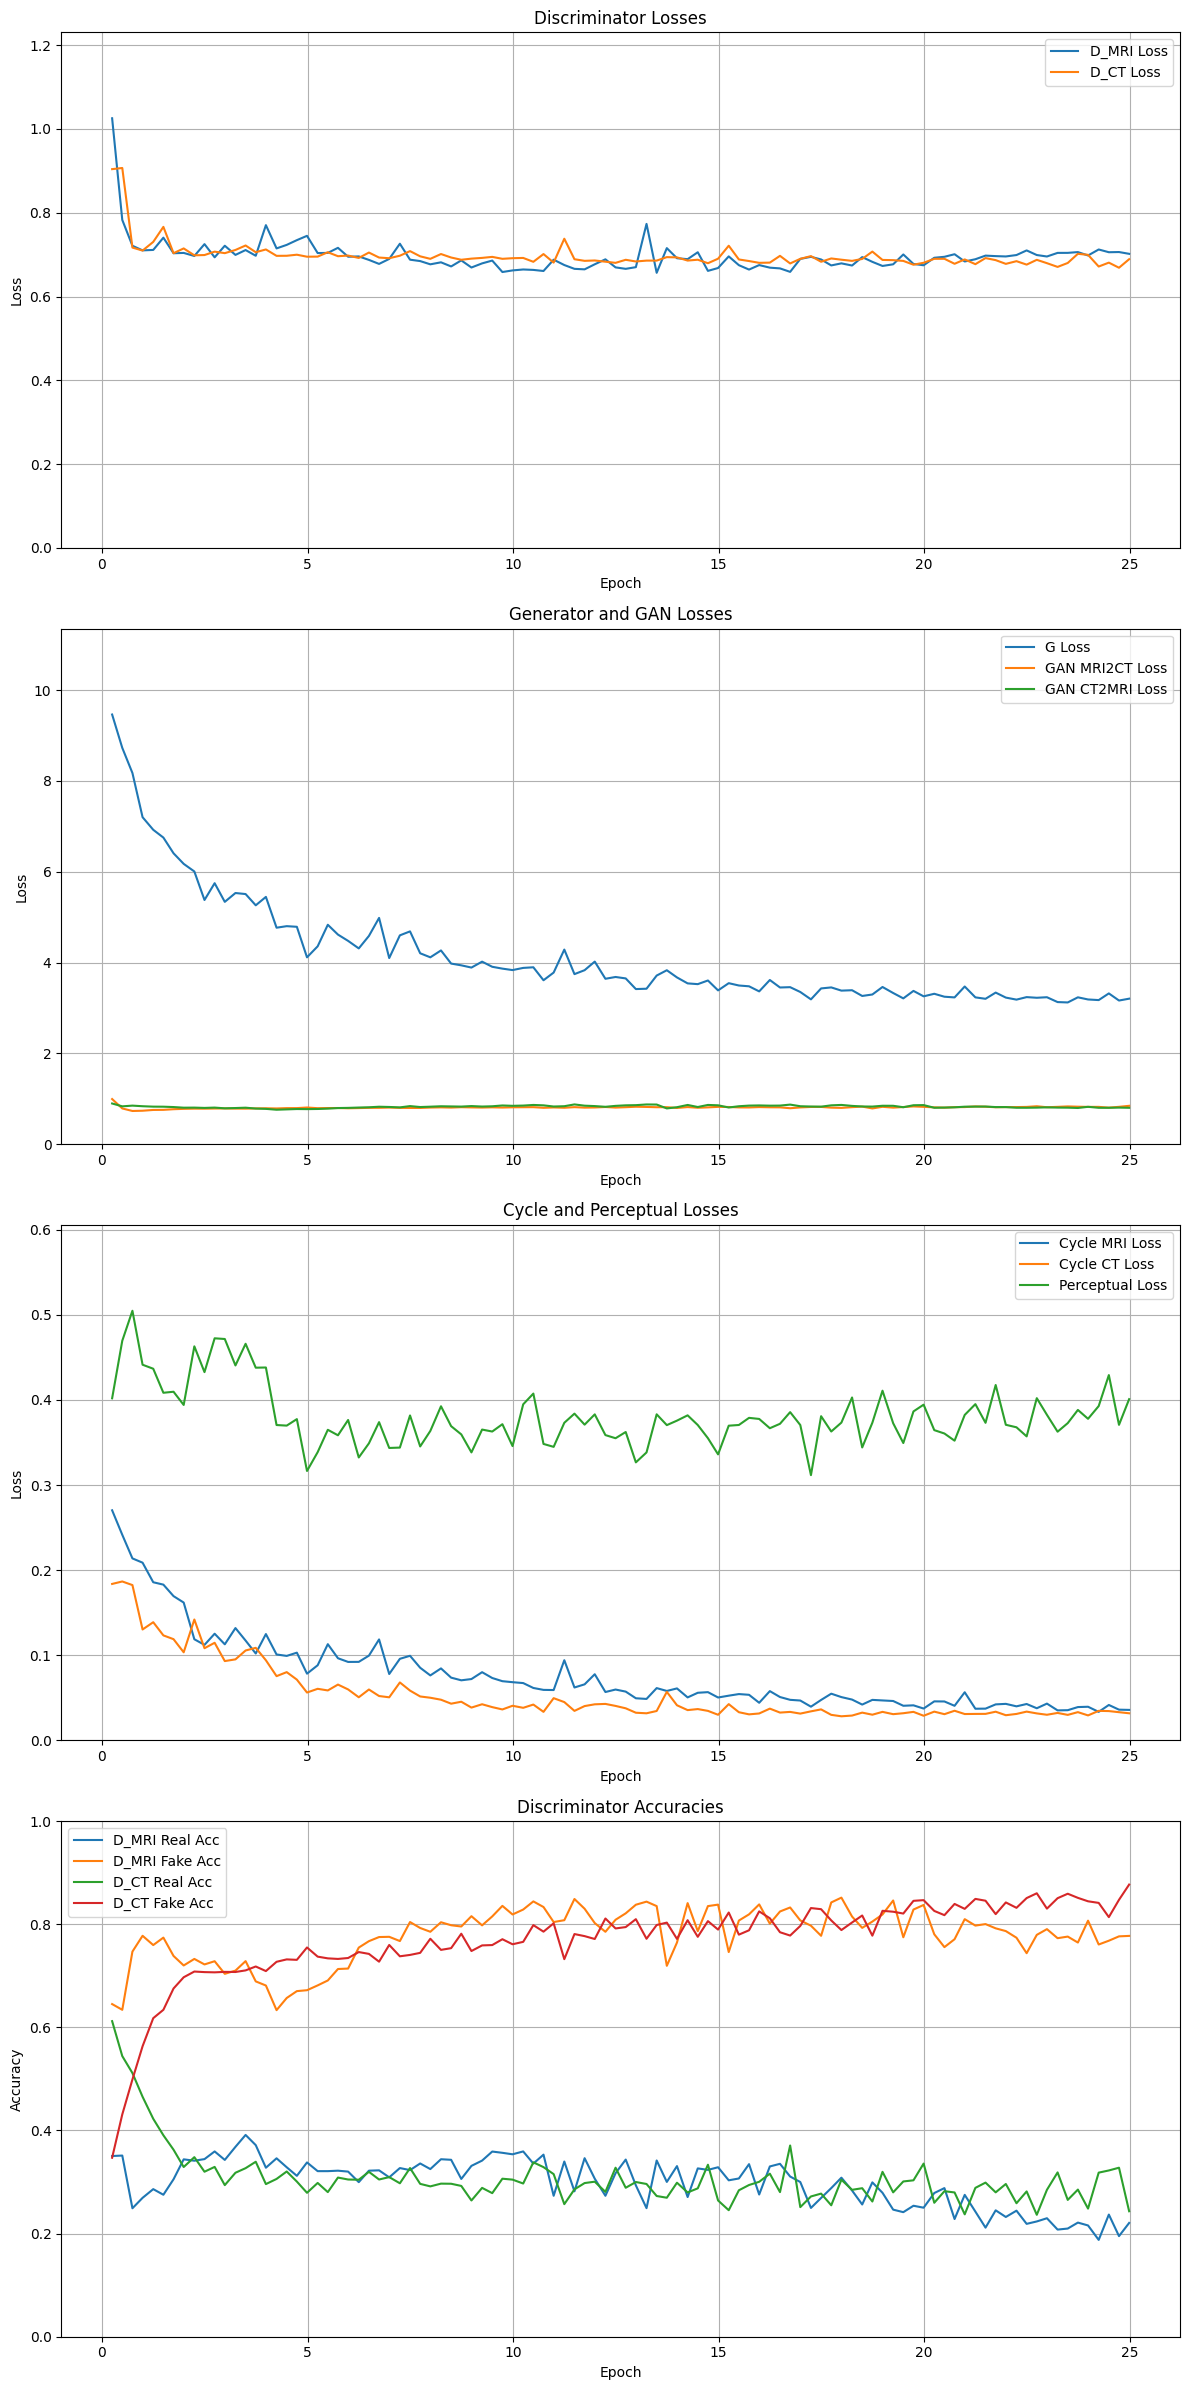

In [8]:
print(validation_metrics)
validation_metrics = validation_metrics
# Plot metrics after training
print(training_metrics)
training_metrics = training_metrics
plot_training_metrics(training_metrics)

{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'MRI MSE': [0.2472374522023731, 0.2630547318193648, 0.17728619111908805, 0.1524079657263226, 0.16589655147658455, 0.22143952051798502, 0.17808478905094993, 0.18503563437196943, 0.14832943346765307, 0.1096756367219819, 0.11445847070879406, 0.05932529146472613, 0.10197174549102783, 0.05861125389734904, 0.03775794141822391, 0.0574415632420116, 0.0915610392888387, 0.09367663909991582, 0.07557007918755214, 0.12576610015498269, 0.07641346090369755, 0.07716469963391621, 0.08140627129210366, 0.05238486536675029, 0.06359554537468487], 'MRI SSIM': [np.float64(0.1356232034912224), np.float64(0.11601584289062175), np.float64(0.7611785866431204), np.float64(0.7562143121243284), np.float64(0.7360913884421323), np.float64(0.6951331791171158), np.float64(0.7212791958021944), np.float64(0.7148402830621475), np.float64(0.7452544541428092), np.float64(0.7593478481967029), np.float64(0.7630989524096013),

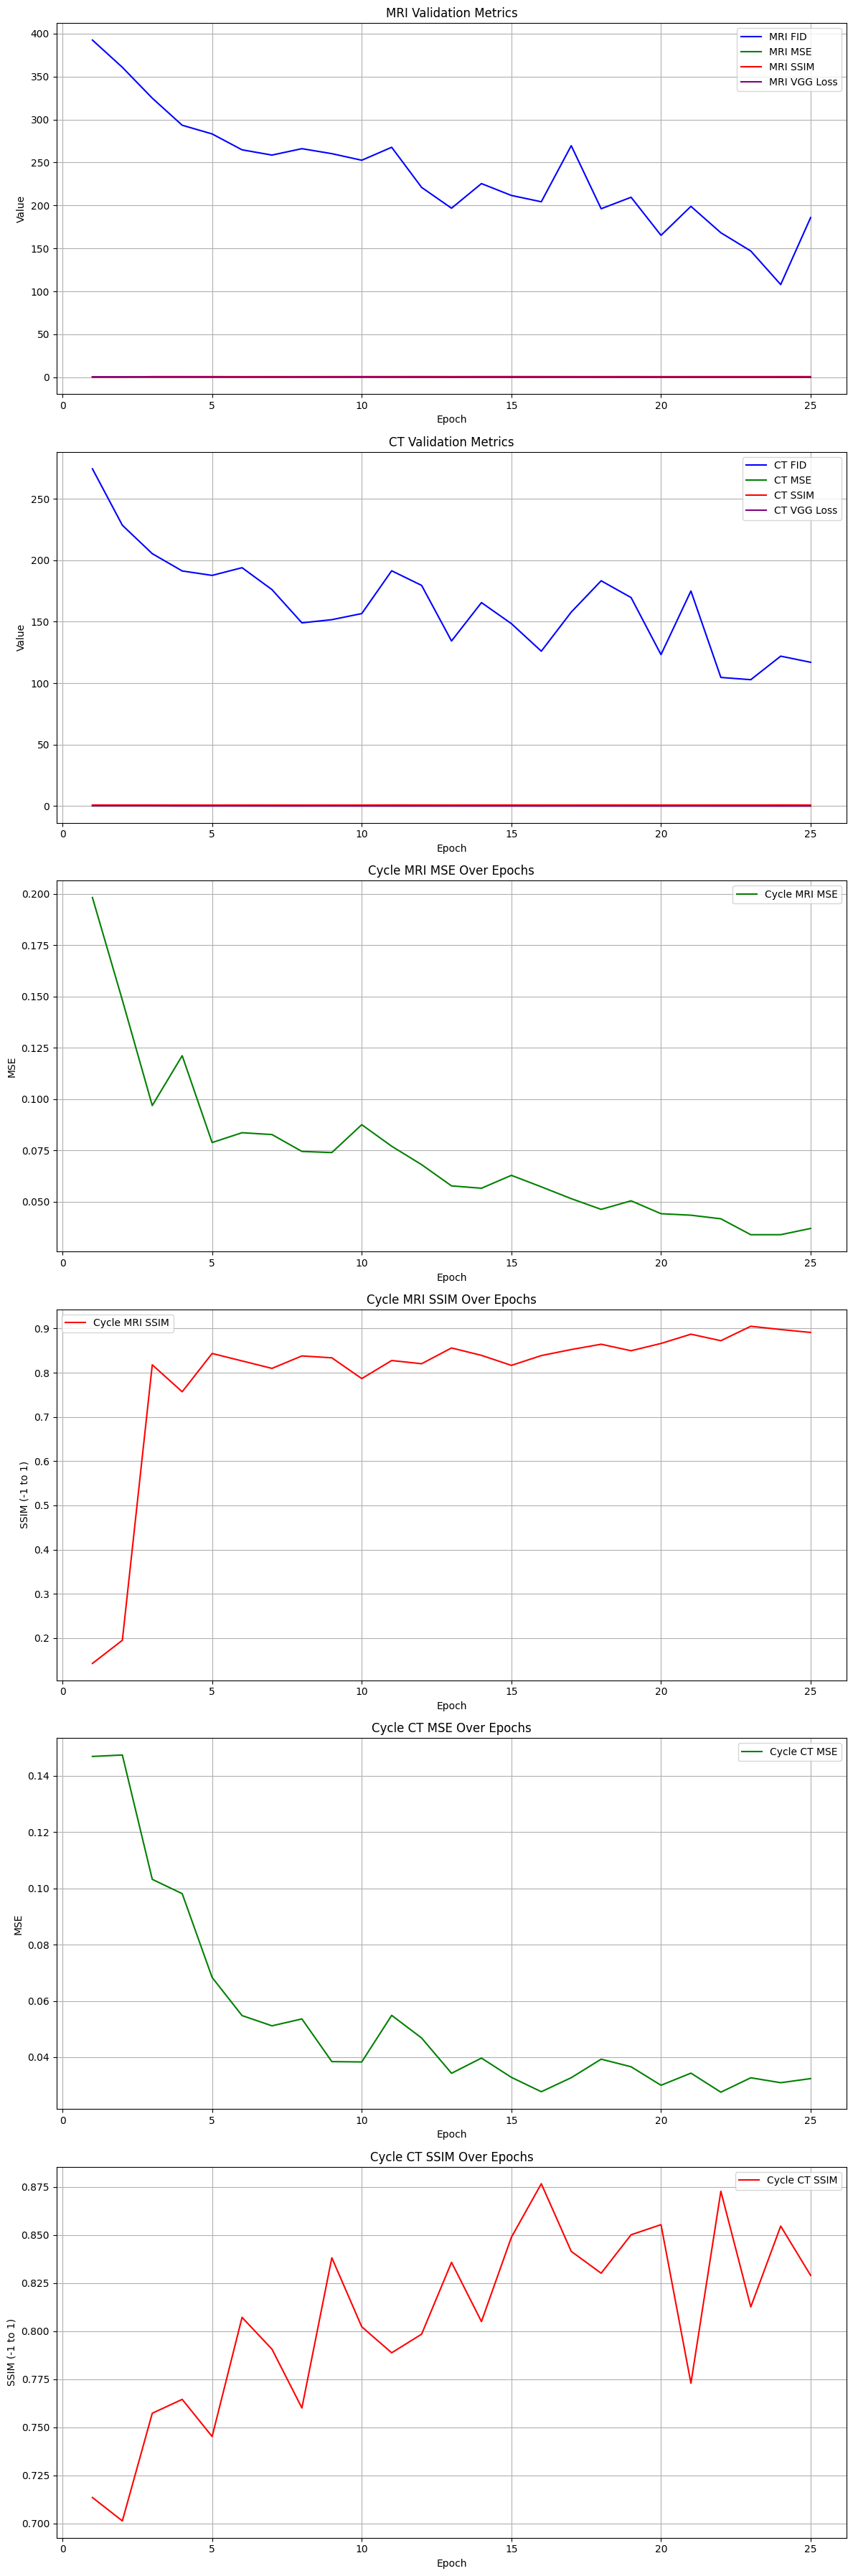

In [9]:
print(validation_metrics)
# validation_metrics = validation_metrics
plot_validation_metrics(validation_metrics)

# 6. Random Patient Test Result's

C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\643957517.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('final_G_MRI2CT.pth'))  

Patient's Test Metric Results -> MSE: 0.132435, SSIM: 0.155663, FID: 279.459686, VGG Loss: 0.248601


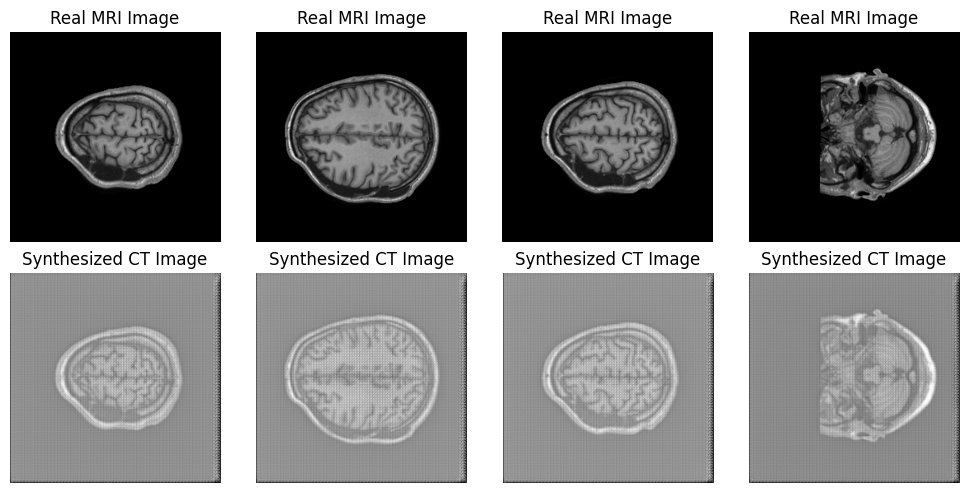

In [10]:
# FOR COLAB
test_input = np.load('./data(brain-new-10)/Test_Patients_InputData/1BA058_input.npy').astype(np.float32)
# Note: test_output is not used since CycleGAN is unpaired
# test_output = np.load('/content/drive/MyDrive/GC folder/mini data/data(brain-10)/Test_Patients_OutputData/1BA058_output.npy').astype(np.float32)

# # FOR PC
# test_input = np.load('./mini data/data(brain-10)/Test_Patients_InputData/1BA058_input.npy').astype(np.float32)
# test_output is not needed for CycleGAN testing

# Create dataset and loader for test MRI data
test_dataset = SingleImageDataset(test_input)
patient_test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Device configuration (from your CycleGAN code)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained generator (G_MRI2CT)
generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load('final_G_MRI2CT.pth'))  # Load the saved model
generator.eval()

# Modified validation function for testing (adapted from your CycleGAN validate function)
def test_validate(G_MRI2CT, test_loader_MRI):
    G_MRI2CT.eval()
    total_mse, total_ssim, total_fid, total_vgg = 0, 0, 0, 0

    # Reuse FID and perceptual loss from your CycleGAN setup
    fid_metric = FrechetInceptionDistance().to(device)
    fid_metric.reset()
    perceptual_loss_fn = VGGPerceptualLoss(device)

    with torch.no_grad():
        for mri_images in test_loader_MRI:
            mri_images = mri_images.to(device)
            fake_ct_images = G_MRI2CT(mri_images)

            # MSE (between fake CT and original MRI as a placeholder; not ideal for unpaired)
            mse = criterion_pixelwise(fake_ct_images, mri_images).item()
            total_mse += mse

            # SSIM (between fake CT and original MRI as a proxy)
            images_np = mri_images.cpu().detach().squeeze(1).numpy()
            fake_np = fake_ct_images.cpu().detach().squeeze(1).numpy()
            ssim_batch = 0
            for i in range(images_np.shape[0]):
                ssim_batch += ssim(images_np[i], fake_np[i], data_range=2.0)
            total_ssim += ssim_batch / images_np.shape[0]

            # FID (between real MRI and fake CT)
            images_3ch = mri_images.repeat(1, 3, 1, 1)
            fake_3ch = fake_ct_images.repeat(1, 3, 1, 1)
            images_3ch = ((images_3ch + 1) / 2 * 255).to(torch.uint8)
            fake_3ch = ((fake_3ch + 1) / 2 * 255).to(torch.uint8)
            fid_metric.update(images_3ch, real=True)
            fid_metric.update(fake_3ch, real=False)
            total_fid += fid_metric.compute().item()
            fid_metric.reset()

            # Perceptual loss (using MRI as reference, though ideally we'd compare to CT)
            vgg_loss = perceptual_loss_fn(fake_ct_images, mri_images).item()
            total_vgg += vgg_loss

    num_batches = len(test_loader_MRI)
    return (
        total_mse / num_batches,
        total_ssim / num_batches,
        total_fid / num_batches,
        total_vgg / num_batches
    )

# Run validation on test data
test_mse, test_ssim, test_fid, test_vgg_loss = test_validate(generator, patient_test_loader)

# Log validation metrics
print("Patient's Test Metric Results -> ", end="")
print(f"MSE: {test_mse:.6f}, SSIM: {test_ssim:.6f}, FID: {test_fid:.6f}, VGG Loss: {test_vgg_loss:.6f}")

# Function to visualize real MRI and synthesized CT images
def visualize_results(generator, patient_test_loader):
    """Visualize real MRI and synthesized CT images for CycleGAN."""
    generator.eval()
    with torch.no_grad():
        # Select 4 random images from the test dataset
        sample_indices = random.sample(range(len(patient_test_loader.dataset)), 4)

        plt.figure(figsize=(10, 5))  # Adjusted size since we only show MRI and fake CT
        for idx, i in enumerate(sample_indices):
            mri_image = patient_test_loader.dataset[i]  # Get the MRI image
            mri_image = mri_image.unsqueeze(0).to(device)  # Add batch dimension
            generated_ct = generator(mri_image).squeeze(0)  # Generate synthetic CT

            # Rescale from [-1, 1] to [0, 1] for visualization
            mri_image = (mri_image + 1) / 2
            generated_ct = (generated_ct + 1) / 2

            # Plot Real MRI Image
            plt.subplot(2, 4, idx + 1)
            plt.imshow(mri_image.cpu().squeeze(), cmap='gray')
            plt.axis('off')
            plt.title('Real MRI Image')

            # Plot Generated CT Image
            plt.subplot(2, 4, idx + 5)
            plt.imshow(generated_ct.cpu().squeeze(), cmap='gray')
            plt.axis('off')
            plt.title('Synthesized CT Image')

        plt.tight_layout()
        plt.show()

# Call the visualization function
visualize_results(generator, patient_test_loader)